In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
import json
import csv

# Text Summary

## Data cleaning

In [214]:
path = 'Dataset for Text Summary Model/text_files/text_files_highlight'

helper function to clean the raw sentences in tos, including NLTK sentence detector, removing html tags, special characters, lower casing, and others

In [388]:
def clean(content):
    #split the content of the file
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    content = tokenizer.tokenize(content)
    # #add space before linebreaker
    content = [x.replace('\n', ' ').replace('e.g. ','e.g.') for x in content]
    content = [re.sub(r'[^\x00-\x7F]+|&nbsp',' ', x) for x in content]
    #replace digit.digit.digit with space
    content = [re.sub('\d+\.\d+\.\d+', ' ', x) for x in content]
    content = [re.sub('\d+\.\d+', ' ', x) for x in content]
    # #remove html tags
    content = [re.sub('<[^<]+?>', '', x) for x in content]
    content = [re.sub('[<;>]+', '', x) for x in content]
    # remove quotation marks
    content = [re.sub('\"|\'', '', x) for x in content]
    # split row into several rows by .
    content = [x.split('. ') for x in content]
    # #flatten the list
    content = [item for sublist in content for item in sublist]
    # #remove extra space
    content = [re.sub(' +', ' ', x) for x in content]
    content = [x.strip() for x in content]
    content = [x for x in content if x != '' and x != '.']
    content = [x.lower() for x in content]
    #remove less than 3 words
    content = [x for x in content if len(x.split()) > 5]
    # #replace'â\x80\x99' with '
    # #drop duplicate
    #remove any character that is not in string.printable
    content = set(content)
    return content       

input the upper of lower ranges of hightlighted sentences in a docs that will be processed for cleaning

In [472]:
def filter(constraint,upper_constraint,save_csv=False):
    if not os.path.exists('Dataset for Text Summary Model/cleaned'):
            os.makedirs('Dataset for Text Summary Model/cleaned')
    output_path = 'Dataset for Text Summary Model/cleaned/more_than_'+str(constraint)+'_sentences'
    #create or reset the output folder
    if save_csv:
        #create the output folder if not exist
        if not os.path.exists(output_path+'/highlight'):
            os.makedirs(output_path+'/highlight')
        else:
            #remove all the files in the folder
            files = os.listdir(output_path+'/highlight')
            for file in files:
                os.remove(output_path+'/highlight/'+file)
        
        if not os.path.exists(output_path+'/original'):
            os.makedirs(output_path+'/original')
        else:
            files = os.listdir(output_path+'/original')
            for file in files:
                os.remove(output_path+'/original/'+file)
        
        if not os.path.exists(output_path+'/combined'):
            os.makedirs(output_path+'/combined')
        else:
            files = os.listdir(output_path+'/combined')
            for file in files:
                os.remove(output_path+'/combined/'+file)
                
    files = os.listdir(path)
    files = [x for x in files if x != '.DS_.txt']

    valid_files = []
    num_sentences_lst = []
    for file in files:
        #open the file
        with open(path+'/'+file, 'r',encoding="utf8") as f:
            #read the highlighted sentences
            content = f.read()
            #clean the highlighted sentences
            content = clean(content)
            #count the number of sentences
            num_sentences = len(content)
            num_sentences_lst.append(num_sentences)
            #if the number of sentence larger than the constraint
            if num_sentences > constraint and num_sentences < upper_constraint:
                valid_files.append(file)
                #save cleaned sentences to csv
                tem = pd.DataFrame(content, columns=['0'])
                #open original text
                with open('Dataset for Text Summary Model/text_files/text_files_raw'+'/'+file, 'r',encoding="utf8") as original:
                    original_txt = original.read()
                    #clean the original text and save to dataframe
                    original_txt = pd.DataFrame({'text':list(clean(original_txt))})
                    #create the combined dataframe
                    combined = original_txt.copy()
                    combined['highlighted'] = 0
                    #if the sentence is in the highlighted sentences, set highlighted to 1
                    for index_c,hightlighted in tem.iterrows():
                        not_found = True
                        for index, row in combined.iterrows():
                            if row['text'] in hightlighted[0] or hightlighted[0] in row['text']:
                                combined.loc[index,'highlighted'] = 1
                                tem.loc[index_c,'0'] = row['text']
                                not_found = False
                        if not_found:
                            tem.drop(index_c, inplace=True)


                    if save_csv:
                        try:
                            tem.drop_duplicates(inplace=True)
                            tem.to_csv(output_path+'/highlight/'+file.replace('.txt','')+'.csv', index=False, header=False)
                            original_txt.to_csv(output_path+'/original/'+file.replace('.txt','')+'.csv', index=False)
                            combined.to_csv(output_path+'/combined/'+file.replace('.txt','')+'.csv', index=False)
                        except:
                            print('Problem in file: ', file, 'Skipping...')
                            continue

    return valid_files, num_sentences_lst

average number of hightlight sentences

In [ ]:
nltk.download('punkt')
valid_files, num_sentences_lst = filter(0)
np.array(num_sentences_lst).mean()

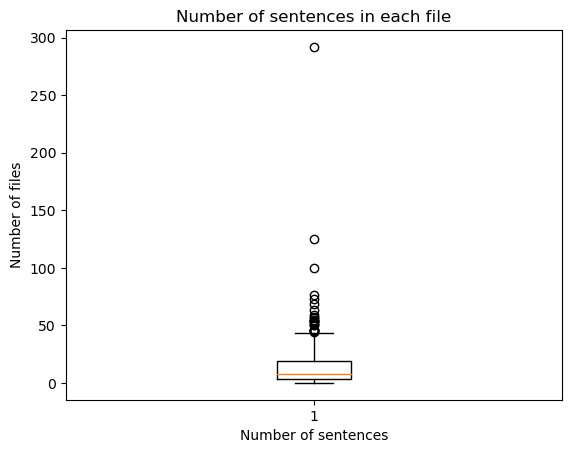

In [470]:
plt.boxplot(num_sentences_lst)
plt.title('Number of sentences in each file')
plt.xlabel('Number of sentences')
plt.ylabel('Number of files')
plt.show()

only keep files with hightlight sentences around 40-50 to avoid infessible gpt-4 output

In [473]:
constraint = 40
upper_constraint = 50
#40 - 50 sentences, clean the data and save to csv
valid_files, num_sentences_lst = filter(constraint,upper_constraint,save_csv=True)

total number of ToS that matched the constraint

In [474]:
len(valid_files)

11

Some example

In [221]:
twothreeandmee = pd.read_csv('Dataset for Text Summary Model/cleaned/more_than_13_sentences/combined/23andMe_Terms of Service.csv')
twothreeandmee.head()

,text,highlighted
0,Your estimated delivery date for your sample c...,0
1,You are solely responsible for paying such fees.,0
2,Official notices related to this tos must be s...,0
3,"If you change your mind about your order, you ...",0
4,23andme's proprietary rights you acknowledge a...,0


overall data

In [222]:
files = os.listdir(f'Dataset for Text Summary Model/cleaned/more_than_'+str(constraint)+'_sentences'+'/combined/')
data = pd.read_csv(f'Dataset for Text Summary Model/cleaned/more_than_'+str(constraint)+'_sentences'+'/combined/'+files[0])
for file in files[1:]:
    df = pd.read_csv(f'Dataset for Text Summary Model/cleaned/more_than_'+str(constraint)+'_sentences'+'/combined/'+file)
    # add df to data dataframe
    data = pd.concat([data,df])
data.shape

(16318, 2)

16318 sentences in total, with 1678 highlighted, 14640 not highlight

In [27]:
data['highlighted'].value_counts()

highlighted
0    14640
1     1678
Name: count, dtype: int64

# The Text Summarization Model

import the requried package from open ai api

In [609]:
import openai
import csv
from summa import summarizer

input your open ai API key for GPT-4 model in the code block below if its not stored in enviorment

In [ ]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [322]:
# Define paths for datasets and the new directory to store result CSVs
constraint = 40  #set to maximum constraint of hightlighted sentences as desired, in this case 40
base_dir = 'Dataset for Text Summary Model/cleaned'
input_dir = os.path.join(base_dir, f'more_than_{constraint}_sentences/original')
output_dir = os.path.join(base_dir, f'more_than_{constraint}_sentences/model_results')

# Make sure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

the final prompt for text hightlight and simplification model

In [739]:
# The system prompt for the OpenAI model
system_prompt = """
---
### Detail Instruction: ###
Using the content in the 'term of service document' given below, and accomplish the following two tasks:
**Hightlight:** Hightlight max 50 indexes that is most important for users to carefully read before accept the term, using the 'definition of important' given below. you can also use your own knowledge to identify 'important' within the Terms of Service documents. Keep a good balance between precision and recall. Obtain the index of highlighted sentences (which line in the document)
**Simplification:** For each hightlighted sentence, based on the document's content, craft a plain-language simplification that is easily understandable for a general audience. Aim for a Gunning Fog index below 9.
Please provide the output in a text file format with 'Highlight' and 'Simplification' as header (first line). And Each line contains the "index" and its corresponding "Simplification" enclosed in quotation marks, and seperated them by a comma.
---
### Steps ###
think step by step,
1. who is the service provider? who are its users population?
2. what should be consider as important sentence for user to read? using the definition given below
3. How can you quantify the importance of a sentence using this definition?
4. What are the 50 most important sentences?
---
### Definition of Important###
A sentence is important if it relates to one or more of the following 57 practices:
1. **Retention of User-Generated Content**: Keeping user content even after the user closes their account.
2. **User Tracking**: Monitoring users on other websites.
3. **Broad Rights Retention**: Retaining rights to user content even after they stop using their account.
4. **Excessive Copyright Claims**: Maintaining copyright over user data/content beyond necessary limits.
5. **Unauthorized Credit Taking**: Taking credit for user-generated content.
6. **Limited Liability**: Restricting liability to fees paid by the user.
7. **Content Licensing to Third Parties**: Licensing user content to external entities.
8. **Third-Party Advertising**: Using user data for targeted third-party advertising.
9. **Cookie Usage**: Implementing third-party cookies despite opt-out instructions.
10. **Account Deletion Without Notice**: Deleting user accounts without notice or explanation.
11. **Username Rejection/Change**: Rejecting or changing usernames arbitrarily.
12. **Involvement of Third Parties**: Engaging third parties in service operations.
13. **Ownership of User Ideas**: Claiming ownership of ideas suggested by users.
14. **No Liability for Unauthorized Access**: Assuming no liability for unauthorized access to user information.
15. **Software Error Negligence**: Not correcting software errors.
16. **Tracking Pixels in Communication**: Using tracking pixels in service-to-user communication.
17. **Extended Data Retention for Analytics**: Keeping anonymized user data beyond retention periods for analytical purposes.
18. **Cross-Product Profile Combination**: Combining user profiles across different products.
19. **Marketing Use of Personal Data**: Using personal data for marketing purposes.
20. **Unlicensed Software Disabling**: Disabling unlicensed software.
21. **Fines for TOS Violations**: Imposing fines for Terms of Service violations.
22. **Referring Web Page Tracking**: Tracking users based on referring web pages.
23. **Binding Arbitration Requirement**: Forcing users into binding arbitration for dispute resolution.
24. **Diverse Personal Data Collection**: Collecting various types of personal data.
25. **Social Media Tracking**: Tracking users via social media cookies/pixels.
26. **Third-Party Information Gathering**: Gathering user information through third parties.
27. **Passive Data Storage**: Storing data on users without their interaction.
28. **Precise Location Collection**: Receiving precise location data through GPS.
29. **Biometric Data Collection**: Collecting biometric data.
30. **Personal Data Selling/Usage**: Selling or using personal data for various purposes.
31. **Terms Change Without Notice**: Changing terms at discretion without notifying users.
32. **Global Data Processing/Storage**: Processing and storing data globally.
33. **Reduced Legal Action Window**: Imposing a shortened time period for legal action.
34. **Opt-Out Ineffectiveness**: Tracking users despite their opting out.
35. **Deleted Content Retention**: Retaining deleted content.
36. **Unexplained Content Deletion**: Deleting specific content without providing reasons.
37. **Sensitive Data for Advertising**: Collecting sensitive data for targeted advertising.
38. **Browsing History Access**: Viewing user browsing history.
39. **Content Blocking/Censorship**: Blocking or censoring user-generated content for any reason.
40. **Limited Operating Jurisdiction**: Operating only in government-approved countries.
41. **Unencrypted Traffic**: Having unencrypted communication.
42. **Government Request Compliance**: Disclosing personal data to comply with government requests without notice.
43. **Identifiable Information Checks**: Verifying provided identifiable information.
44. **Private Message Reading**: Reading private user messages.
45. **Price/Fee Changes Without Notice**: Changing prices and fees without notifying users.
46. **Indefinite Log Keeping**: Keeping logs for an undefined period.
47. **Retroactive Policy Changes**: Applying policy changes retroactively.
48. **AI Training/Decision-Making with Personal Data**: Using personal data for decision-making, profiling, or AI training.
49. **Assumed Consent from Usage**: Assuming user consent to term changes through usage.
50. **Promotional Communication Difficulty**: Making it hard for users to opt out of promotional communications.
51. **Name Requirement Enforcement**: Refusing pseudonyms and insisting on legal names.
52. **Personal Data Accessibility Challenges**: Making it inconvenient for users to obtain their personal data.
53. **Interference Prevention**: Preventing interference with others' enjoyment of the service.
54. **Negative Opinion Disallowance**: Disallowing negative opinions about the service.
55. **Value-Advocacy Restrictions**: Prohibiting discussions against government-advocated values.
56. **Content Removal/Editing Restrictions**: Restricting the removal or editing of user-generated content.
57. **Implied Waivers of Rights**: Implying user waivers of moral rights and the right to a class action.
---
### Output Format ###
Highlight,Summary
"index","Simplification 1"
"index","Simplification 2"
...
"index","Simplification 50"
---
### Additional requirements ###
1. The output should only contains the format listed above, turn off any warning or error message. 
2. If the text is too long, please only the most important part of the text.
3. Please use any tools or knowledges to help you complete the task
4. cleaned the 'simplification' to the requried output format.
---
"""

feed the prompt into the gpt-4-turbo-preview model

In [ ]:

# Loop through all CSV files in the input directory
def process_csv(csv_file_name):
    csv_file_path = os.path.join(input_dir, csv_file_name)
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Join all text entries into one large string to feed into the model
    #add service provider and term of service document
    text_to_summarize = '\n --- \n ### service provider ###'+csv_file_name.split('_')[0]+'\n ### term of service document ### \n'
    for index,text in df.iterrows():
        text_to_summarize +='index'+str(index) + ': ' + text['text'] + '\n'
        
    text_to_summarize += "--- END OF DOCUMENT ---"

    # Headers for the POST request
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {OPENAI_API_KEY}'
    }

    # Data payload for the POST request
    data = {
        'model': 'gpt-4-1106-preview',
        'messages': [
            {"role": "system", "content": 'You are a helpfull assistant.'},
            {"role": "user", "content": system_prompt + text_to_summarize}
        ],
    }

    # URL for the OpenAI API chat completions endpoint
    url = 'https://api.openai.com/v1/chat/completions'

    # Make the POST request to the OpenAI API
    response = requests.post(url, headers=headers, data=json.dumps(data))

    # Check if the request was successful
    if response.status_code == 200:
        # Extract and format the completion output
        response_data = response.json()
        generated_output = response_data['choices'][0]['message']['content']
         #save generated output as csv
        # with open('Dataset for Text Summary Model/cleaned/more_than_20_sentences/model_results/'+csv_file_name.replace('.csv','')+'_generated_output.csv', 'w',encoding="utf8") as f:
        #     f.write(generated_output)
        # parsed_output = [(part.split('\n')[0].replace('Highlight: ', '').strip(), 
        #                   part.split('\n')[1].replace('Summary: ', '').strip())
        #                  for part in output_lines if len(part.split('\n')) == 2]

        # Write the summaries to a new CSV file in the output directory
        baseline = summarizer.summarize(text_to_summarize)
        baseline_df = pd.DataFrame([baseline.split('\n')]).T
        baseline_df.to_csv(os.path.join(output_dir, csv_file_name.replace('.csv', '_baseline.csv')), index=False)
        output_csv_path = os.path.join(output_dir, csv_file_name.replace('.csv', '_summary.csv'))
        # with open(output_csv_path, 'w', newline='', encoding='utf-8') as csv_file:
        with open(output_csv_path, 'w', newline='', encoding='utf-8') as csv_file:
            csv_file.write(generated_output)
            # writer = csv.writer(csv_file)
            # writer.writerow(['Highlighted Clause', 'Plain Language Summary'])
            # writer.writerows(parsed_output)
            
        print(f"Processed CSV: {csv_file_name}")
    else:
        print(f"Failed to get a response from the OpenAI API. Status code: {response.status_code}, Response: {response.text}")
    return text_to_summarize

Loop through inputs docs, feed into gpt4, and save the outout to out_dic

In [740]:
# Iterate over CSV files in the directory and process each with GPT-4
num_docs = 0
#set the number of files to process, we frist used 5 docs for prompt engineering, and used 10 docs for the evluation
holds = 10
files = os.listdir(output_dir)
for file in files:
    os.remove(output_dir+'/'+file)
for csv_file_name in os.listdir(input_dir):
    if (num_docs < holds) and csv_file_name.endswith('.csv'):  # Process only CSV files
        text = process_csv(csv_file_name)
        num_docs += 1

print(f"All CSV files have been processed and the results are saved in {output_dir}")

Processed CSV: Pinterest_Terms of Service.csv
Processed CSV: LBRY_Terms of Service.csv
Processed CSV: Tumblr_Terms of Service.csv
Processed CSV: IDrive_Terms of Service.csv
Processed CSV: Crunchyroll_Terms of Service.csv
Processed CSV: Pure Dating_Terms of Service.csv
Processed CSV: HuffPost_Terms of Service.csv
Processed CSV: Google_Terms of Service.csv
Processed CSV: Goodreads_Terms of Service.csv
Processed CSV: FileFactory_Terms of Service.csv
All CSV files have been processed and the results are saved in Dataset for Text Summary Model/cleaned/more_than_40_sentences/model_results


output of all ToS is now created from GPT-4 model and stored into the output location. We will used them to evaluation with the ground truth ('hightlight' column in 'orginal')

# Evaluation of Highlighting Function 

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [756]:
# create the word embedding model to compare the similiarity between sentences to avoid mismatch due to small difference when using exact match
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

#helper parameter to count number of docs processed
num_docs = 0

# Paths to the directories containing the actual and predicted CSV files
actual_dir = f'Dataset for Text Summary Model/cleaned/more_than_{constraint}_sentences/combined'
predicted_dir = f'Dataset for Text Summary Model/cleaned/more_than_{constraint}_sentences/model_results'
not_matched  = []

# Lists of score
avg_p = []
avg_r = []
avg_f1 = []
#for baseline text rank model
avg_p_baseline = []
avg_r_baseline = []
avg_f1_baseline = []

# Function to check if either the predicted sentence is in any of the actual sentences, or vice versa using the similarity score
def is_match(predicted_sentence,actual_sentence_embeddings):
    predicted_sentence_embeddings = model.encode([predicted_sentence])
    for i in range(len(actual_sentence_embeddings)):
        cos_sim = cosine_similarity([predicted_sentence_embeddings[0]], [actual_sentence_embeddings[i]])[0][0]
        #set the threshold of cosine similarity to 0.7
        if cos_sim > 0.7:
            return True,i
    return False,None

# Loop over the actual labeled CSV files
for predicted_file in os.listdir(predicted_dir):
    if predicted_file.endswith('_summary.csv'):
        # store the list of matched and not matched sentences for debugging and prompt engineering
        matched = []
        predicted = []
        match_baseline = []

        #print the current file name
        print(f'Processing {predicted_file}...')

        #get the file name that containing the ground truth highlighted sentences
        actual_file = predicted_file.replace('_summary', '')
        actual_path = os.path.join(actual_dir, actual_file)
        actual_df = pd.read_csv(actual_path,encoding="utf8")
        #obtain the hightlighted sentences
        hightlighted = actual_df[actual_df['highlighted']==1]

        try:
            #get the output from gpt-4 and baseline model
            predicted_path = os.path.join(predicted_dir, predicted_file)
            predicted_df = pd.read_csv(predicted_path,encoding="utf8")
            baseline_df = pd.read_csv(predicted_path.replace('_summary', '_baseline'),encoding="utf8")

            #get the highlighted sentences from the baseline model
            baseline_sentences = baseline_df.iloc[:, 0].tolist()
            #get index from gpt-4 output (we used index as output in gpt-4 to reduce output token, but required to match them back with original sentences)
            predicted_sentences = [actual_df.iloc[int(re.sub(r'[^\d]+', '', i)),0] for i in predicted_df['Highlight']]

            #store the original sentences of output from gpt-4 after matching with the index for text classification model
            hightlight_summary = predicted_df.copy()
            hightlight_summary['Highlight'] = predicted_sentences
            hightlight_summary.to_csv(predicted_path.replace('_summary', '_original_sentences'), index=False)

            #created word embedding for both gpt-4 output and baseline sentences to match with cosine similarity
            predicted_sentences_embeddings = model.encode(predicted_sentences)
            baseline_sentences_embeddings = model.encode(baseline_sentences)

            #check wether the grouth truth highlighted sentences are in the output from gpt-4 and baseline model
            for index, row in hightlighted.iterrows():
                result, index_result = is_match(row['text'],predicted_sentences_embeddings)
                result_baseline, index_result_baseline = is_match(row['text'],baseline_sentences_embeddings)
                #if in the output from gpt-4, store the matched sentences
                if result:
                    matched.append(row['text'])
                    predicted.append(predicted_sentences[index_result])
                else:
                    #append to not matched list for debugging (tune the cosine similiary threshold)
                    not_matched.append(row['text'])

                #if in the output from baseline model, store the matched sentences
                if result_baseline:
                    match_baseline.append(baseline_sentences[index_result_baseline])

            #calculate the precision, recall and f1 score for both gpt-4 and baseline model
            precsion = len(matched)/len(predicted_sentences)
            precsion_baseline = len(match_baseline)/len(baseline_sentences)
            recall = len(matched)/hightlighted.shape[0]
            recall_baseline = len(match_baseline)/hightlighted.shape[0]
            f1 = 2*(precsion*recall)/(precsion+recall)
            f1_baseline = 2*(precsion_baseline*recall_baseline)/(precsion_baseline+recall_baseline)

            #store the not matched sentences into a csv for human judges to check whether are important sentences in gpt-4 output
            not_predicted = [x for x in predicted_sentences if x not in predicted]
            not_predicted_df = pd.DataFrame(not_predicted, columns=['0'])
            not_predicted_df.to_csv('Dataset for Text Summary Model/cleaned/more_than_40_sentences/model_results/'+predicted_file.replace('.csv','')+'_not_predicted.csv', index=False, header=False)

            #find the average score for all files
            avg_p.append(precsion)
            avg_r.append(recall)
            avg_f1.append(f1)

            avg_p_baseline.append(precsion_baseline)
            avg_r_baseline.append(recall_baseline)
            avg_f1_baseline.append(f1_baseline)

        except Exception as e:
            print('Problem in file: ', predicted_file, 'Skipping...')
            print(e)
            continue
#printing the average score for all files
print(f'LLMs Precision: {np.mean(avg_p)} Baseline Precision: {np.mean(avg_p_baseline)}')
print(f'LLMs Recall: {np.mean(avg_r)} Baseline Recall: {np.mean(avg_r_baseline)}')
print(f'F1 Score: {np.mean(avg_f1)} Baseline F1 Score: {np.mean(avg_f1_baseline)}')


Processing LBRY_Terms of Service_summary.csv...
Processing Google_Terms of Service_summary.csv...
Processing Crunchyroll_Terms of Service_summary.csv...
Processing Pure Dating_Terms of Service_summary.csv...
Processing IDrive_Terms of Service_summary.csv...
Processing FileFactory_Terms of Service_summary.csv...
Processing Pinterest_Terms of Service_summary.csv...
Processing Goodreads_Terms of Service_summary.csv...
Processing HuffPost_Terms of Service_summary.csv...
Processing Tumblr_Terms of Service_summary.csv...
LLMs Precision: 0.43289305771630887 Baseline Precision: 0.3904402923535385
LLMs Recall: 0.6426770487064604 Baseline Recall: 0.3396916195677806
F1 Score: 0.5120393486071904 Baseline F1 Score: 0.3538497694962238


basedline f1 for all files

In [754]:
avg_f1_baseline

[0.19999999999999998,
 0.2962962962962963,
 0.4155844155844156,
 0.29850746268656714,
 0.21176470588235297,
 0.380952380952381,
 0.5079365079365079,
 0.5245901639344263,
 0.2156862745098039,
 0.48717948717948717]

# Evaluation of Simplification Function

In [751]:
from readability import Readability
from evaluate import load
#store the readability score and bert score for all hightlighted sentences and its simplification
original_sentences_readability = []
simlified_sentences_readability = []
bert = []
bertscore = load("bertscore")

for predicted_file in os.listdir(predicted_dir):
    if predicted_file.endswith('_summary.csv'):
        print(f'Processing {predicted_file}...')
        predicted_path = os.path.join(predicted_dir, predicted_file)
        
        actual_file = predicted_file.replace('_summary', '')
        actual_path = os.path.join(actual_dir, actual_file)
        actual_df = pd.read_csv(actual_path,encoding="utf8")
        try:
            predicted_df = pd.read_csv(predicted_path,encoding="utf8")
            #match the index of gpt-4 output with the original sentences
            original_sentences_lst = [actual_df.iloc[int(re.sub(r'[^\d]+', '', i)),0] for i in predicted_df['Highlight']]
            #get the simiplified sentences for each original sentences for gpt-4 output
            simplified_sentences_lst = predicted_df.iloc[:, 1].tolist()
            #group all sentences into one string
            original_sentences = ' '.join(original_sentences_lst)
            simplified_sentences = ' '.join(simplified_sentences_lst)
            #check the readability score for both original and simplified sentences
            original_sentences_readability.append(Readability(original_sentences).flesch_kincaid().score)
            simlified_sentences_readability.append(Readability(simplified_sentences).flesch_kincaid().score)
            #check the bert score for simplified sentences
            score = bertscore.compute(references = original_sentences_lst, predictions=simplified_sentences_lst,model_type="distilbert-base-uncased")
            bert.append(score)
        
        except Exception as e:
            print('Problem in file: ', predicted_file, 'Skipping...')
            print(e)
print('----------------------------------')
print('The original sentences readability:',original_sentences_readability,'Mean:',np.mean(original_sentences_readability))
print('The simplified sentences readability:',simlified_sentences_readability,'Mean:',np.mean(simlified_sentences_readability))
print('----------------------------------')
print('The Percision:',[np.mean(bert[i]['precision']) for i in range(len(bert))],'Mean:',np.mean([np.mean(bert[i]['precision']) for i in range(len(bert))]))
print('The Recall:',[np.mean(bert[i]['recall']) for i in range(len(bert))],'Mean:',np.mean([np.mean(bert[i]['recall']) for i in range(len(bert))]))
print('The F1:',[np.mean(bert[i]['f1']) for i in range(len(bert))],'Mean:',np.mean([np.mean(bert[i]['f1']) for i in range(len(bert))]))

Processing LBRY_Terms of Service_summary.csv...
Processing Google_Terms of Service_summary.csv...
Processing Crunchyroll_Terms of Service_summary.csv...
Processing Pure Dating_Terms of Service_summary.csv...
Processing IDrive_Terms of Service_summary.csv...
Processing FileFactory_Terms of Service_summary.csv...
Processing Pinterest_Terms of Service_summary.csv...
Processing Goodreads_Terms of Service_summary.csv...
Processing HuffPost_Terms of Service_summary.csv...
Processing Tumblr_Terms of Service_summary.csv...
----------------------------------
The original sentences readability: [19.683446288512375, 36.45683901004655, 22.577185360716168, 19.727058527915677, 16.57536130536131, 23.190247658543402, 17.028105071363502, 15.778694822956663, 20.406358386535114, 16.983099755670782] Mean: 20.840639618762157
The simplified sentences readability: [7.010705515364705, 11.556400652295775, 8.435733637747337, 8.473316508832866, 7.062426194310252, 8.13877512885275, 7.495285621340276, 6.1287032490